# 0. HG-PD：即我们的模型，$\text{exp}_3$/HG-PD: our proposed model, $\text{exp}_3$

这个jupyter文件仅包含了我们所提出的模型HG-PD的训练过程（即 $\text{exp}_3$）

This jupyter file only includes all training processes related to our proposed model HG-PD. i.e., $\text{exp}_3$

## 0.1 导入库/Import library

In [1]:
'''Basic'''
import os
import time
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px
from datetime import datetime
import re
import emoji
import multiprocessing

'''Sklearn'''
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

'''Cluster'''
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans

'''Text processing'''
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import BertTokenizer, BertModel
import jieba
from bs4 import BeautifulSoup

'''Hetero graph'''
from torch_geometric.data import HeteroData

'''Training and NN'''
import torch
import torch.optim as optim
from mcr2_HGPD import MCR2_HGPD
from mcrLoss import MaximalCodingRateReduction
from augment import AugmentLoader
import savePara

'''Random seed'''
torch.manual_seed(0)
np.random.seed(0)

确定transformers的版本号/Confirm library version

In [2]:
import transformers
print(transformers.__version__)
print(torch.__version__)

4.31.0
2.0.0+cu118


## 0.2 读取数据/Read data

In [3]:
'''csv文件/csv file'''
user_data=pd.read_csv('Datasets/UserData.csv')
profile_data=pd.read_csv('Datasets/UserProfile.csv')

user_feature = pd.read_csv('Datasets/UserFeature_Graph.csv')
user_inter = pd.read_csv('Datasets/UserInter_Graph.csv')
hetero_data = pd.read_csv('Datasets/Sina_allInfo.csv')
user_comment = pd.read_csv('Datasets/UserPost.csv')

'''Tensor'''
user_f = torch.load("Tensor/user_f.pt")
user_embed_idx = torch.load("Tensor/user_embed_idx.pt")
userInter_data = torch.load("Tensor/userInter_data.pt")
userInter_self = torch.load("Tensor/userInter_self.pt")
s_user_f = torch.load('Tensor/s_user_f.pt')
heteroData = torch.load('Tensor/HeteroData.pt')

comm_f = torch.load("Tensor/Comment_Vector.pt")
userPost_comm = torch.load("Tensor/userPost_comm.pt")

# 1. HG-PD 帮助文档/HG-PD Helper

模型训练涉及的脚本将在这里被介绍

The documentation of each Python script related to model training will be introduced in this section

## 1.1 Model: mcr2_HGPD.py
- Red: the default value in our case (based on our Genshin Dataset)
- Yellow: hyperparameter

- __ init __(self, node_num, feature_dim, cate_dim, hidden_dim, num_hop)
  - Parameter
    - node_num: the number of user nodes with missing profiles<br>**<span style="color:red">980</span>**
    - feature_dim: the number/dimension of the initial user nodes' features<br>**<span style="color:red">10</span>**
    - cate_dim: the dimension of each binary variable transformed by a embedding layer (e.g., if $v_{n \times 1}$ is transformed to $v'_{n \times 10}$, then cate_dim=10)<br>**<span style="color:yellow">Customizable</span>**
    - hidden_dim: the dimension of GNNs' hidden layer<br>**<span style="color:yellow">Customizable</span>**
    - num_hop: the number of hop/range of neighbour nodes for message passing<br>**<span style="color:yellow">Customizable</span>**
  - self.embedding: generate "pseudo profiles" for users without profiles via embedding layer
  - self.convs = torch.nn.ModuleList(): HeteroGNNs
- forward
  - Parameter
    - no_Nidx: the embedding index for users withough profiles<br>**<span style="color:red">user_embed_idx</span>**
    - u_feature: the standardized user nodes' features for users with profiles<br>**<span style="color:red">s_user_f</span>**
    - heteData: the pre-defined HeteroG<br>**<span style="color:red">heteroData</span>**
  - Remeber: we only need the representations of user nodes for user clustering

## 1.2 Loss function: mcrLoss.py

<font color='red'>注意以下参数名的对应</font>
- <font color='red'>论文：$\gamma_1$ -> 代码：gam2</font>
- <font color='red'>论文：$\epsilon^2$ -> 代码：eps</font>

<font color='yellow'>Hint: the correspondence of the parameters names between thesis and code are:</font>
- <font color='yellow'>Paper: $\gamma_1$ -> Code: gam2</font>
- <font color='yellow'>Paper: $\epsilon^2$ -> Code: eps</font>

- self.eff: whether smoothing is needed between the discriminative and compressive term<br>**<span style="color:yellow">Default `False`</span>**

## 1.3 Data augmentation and batch allocation: AugmentLoader.py

- Key parameters:
  - data: user nodes representation from the model
  - batch_size: the size of each batch
  - aug_num: the number of the specific data point after augmentation (e.g., if 1 data point is augmented to 10, then aug_num=10)

## 1.4 Transform the pseudo label to the membership matrix $\Pi$: Other_function.py

This python scripted is called in mcrLoss.py

## 1.5 Save parameters and model states: savePara.py

This script will be used in the model training to save parameters and model states

# 2. 模型训练/Model training

##  2.1 Model 1 (M1: $\gamma_1 = 1$, $\mathrm{smooth} = \mathrm{False}$)

### (1) 参数/Parameter

- MCR2_HGPD
  - cate_dim = 8
  - hidden_dim = 16
  - num_hop = 2
- mcr_loss
  - eff = False (without smooth)
  - eps = 0.5
  - gam2 = 1 (without scale of Discrim in loss calculation)
- optimizer & train
  - torch.optim.Adam(net.parameters(), lr=0.001)
  - epoch = 200
- AugmentLoader
  - batch_size = 20
  - aug_num = 50

### (2) 模型训练/Model training

In [4]:
torch.manual_seed(0)
net = MCR2_HGPD(node_num=980, feature_dim=10, cate_dim=8, hidden_dim=16, num_hop=2)

In [5]:
mcr_loss = MaximalCodingRateReduction(eps = 0.5, gam2 = 1)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [6]:
best_folder = 'Train_record/Model/Model1/Best'
model_folder = 'Train_record/Model/Model1/Model state'
params_folder = 'Train_record/Model/Model1/Parameter'
np_path = 'Train_record/Model/Model1/All_loss.npy'

In [7]:
epoch_num = 200
loss_stand = 0
loss_array = np.zeros(epoch_num)
m_start_time = time.time()
torch.manual_seed(0)
np.random.seed(0)
net.train()
for epoch in range(epoch_num):
    node_user = net(no_Nidx = user_embed_idx,
                    u_feature = s_user_f,
                    heteData = heteroData)
    data_loader = AugmentLoader(node_user,
                                batch_size = 20,
                                aug_num = 50,
                                shuffle = False)
    loss_s = torch.tensor(0.0,requires_grad=True,device='cuda')
    '''把所有batch的loss加和；每个epoch结束后回传一次loss / Sum the loss of all batch; BP the loss at the end of each epoch'''
    for step, (batch, pseudo_label) in enumerate(data_loader):
        batch = batch.cuda()
        loss, loss_empi, loss_theo = mcr_loss(batch, 
                                              pseudo_label)
        loss_s = torch.add(loss_s, loss)
        
        if step == 0:
            step_savename = 'Model1_step.csv'
            savePara.save_step_DC(step_savename, params_folder,
                                  epoch, step,
                                  loss.item(), loss_empi[0], loss_empi[1], 
                                  loss_theo[0], loss_theo[1]) 
        elif (step+1) % 50 == 0:
            step_savename = 'Model1_step.csv'
            savePara.save_step_DC(step_savename, params_folder,
                                  epoch, step,
                                  loss.item(), loss_empi[0], loss_empi[1], 
                                  loss_theo[0], loss_theo[1])         

    optimizer.zero_grad()
    loss_s.backward()
    optimizer.step()
        
    
    loss_compare = loss_s.detach().item()
    loss_array[epoch] = loss_compare
    print(f'{epoch+1}, {loss_compare}')
    if loss_compare < loss_stand:
        model_savename = f'1Best_epoch{epoch + 1}.pt'
        savePara.save_model_state(model_savename, best_folder,
                                  epoch, net, optimizer)
        loss_stand = loss_compare
        print('Now the best is: {}'.format(epoch+1))
           
    if epoch == 0:
        model_savename = f'Model1_epoch{epoch + 1}.pt'
        savePara.save_model_state(model_savename, model_folder, 
                                  epoch, net, optimizer)
    elif (epoch+1) % 25 == 0:
        model_savename = f'Model1_epoch{epoch + 1}.pt'
        savePara.save_model_state(model_savename, model_folder, 
                                  epoch, net, optimizer)
    
    if epoch == 0:
        params_savename = 'Model1_params.csv'
        savePara.save_parameters_to_csv(params_savename, params_folder, 
                                        epoch, loss_s.item(), 0.001)
        
    elif (epoch+1) % 10 == 0:
        params_savename = 'Model1_params.csv'
        savePara.save_parameters_to_csv(params_savename, params_folder, 
                                        epoch, loss_s.item(), 0.001)
        print('Epoch {} finished!'.format(epoch+1))
        
m_end_time = time.time()
m_total_time = (m_end_time - m_start_time)/3600
np.save(np_path, loss_array)
print("Training complete! Total training time: {} hours".format(m_total_time))

1, -5182.87744140625
Now the best is: 1
2, -5230.09326171875
Now the best is: 2
3, -5237.19970703125
Now the best is: 3
4, -5252.37744140625
Now the best is: 4
5, -5273.7060546875
Now the best is: 5
6, -5281.34423828125
Now the best is: 6
7, -5286.69384765625
Now the best is: 7
8, -5302.775390625
Now the best is: 8
9, -5309.05615234375
Now the best is: 9
10, -5314.20751953125
Now the best is: 10
Epoch 10 finished!
11, -5318.869140625
Now the best is: 11
12, -5330.78662109375
Now the best is: 12
13, -5335.51806640625
Now the best is: 13
14, -5344.2861328125
Now the best is: 14
15, -5352.35986328125
Now the best is: 15
16, -5352.349609375
17, -5358.18994140625
Now the best is: 17
18, -5363.99853515625
Now the best is: 18
19, -5370.05224609375
Now the best is: 19
20, -5370.73046875
Now the best is: 20
Epoch 20 finished!
21, -5376.15185546875
Now the best is: 21
22, -5380.06005859375
Now the best is: 22
23, -5378.05224609375
24, -5387.22998046875
Now the best is: 24
25, -5390.79052734375
N

### (3) Loss可视化/Loss visualization

In [4]:
np_path = 'Train_record/Model/Model1/All_loss.npy'
loss1 = np.load(np_path)

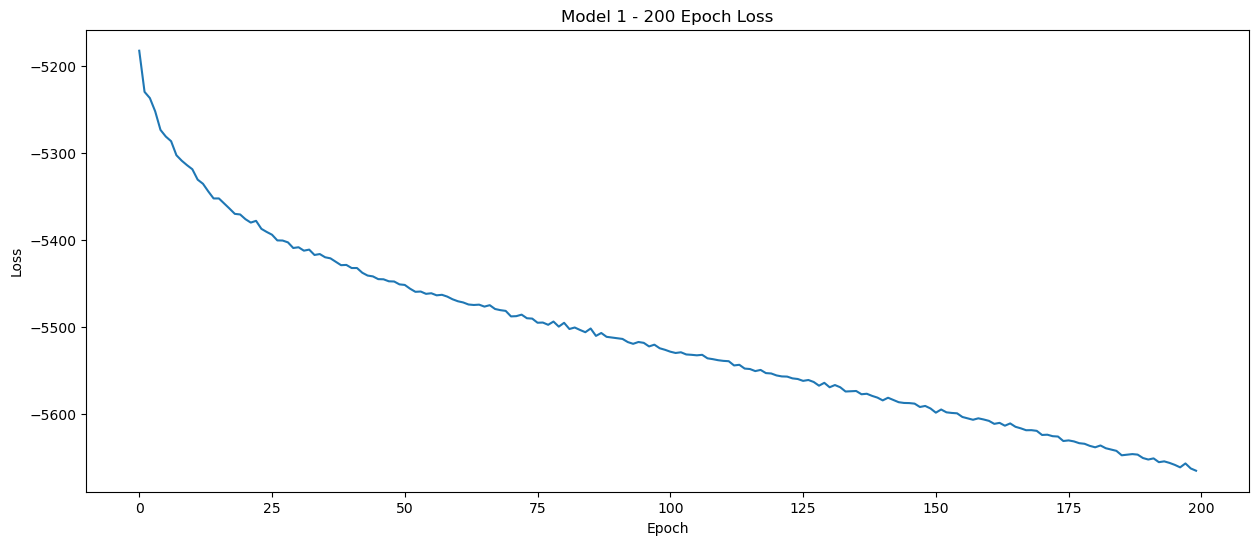

In [5]:
plt.figure(figsize=(15,6))
plt.plot(loss1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1 - 200 Epoch Loss')
plt.show()

##  2.2 Model 2 (M1: $\gamma_1 = 0.6$, $\mathrm{smooth} = \mathrm{False}$)

### (1) 参数/Parameter

- MCR2_HGPD
  - cate_dim = 8
  - hidden_dim = 16
  - num_hop = 2
- mcr_loss
  - eff = False (without smooth)
  - eps = 0.5
  - gam2 = 0.6 (Default scale of Discrim in loss calculation)
- optimizer & train
  - torch.optim.Adam(net.parameters(), lr=0.001)
  - epoch = 200
- AugmentLoader
  - batch_size = 20
  - aug_num = 50


### (2) 模型训练/Model training

In [4]:
torch.manual_seed(0)
net = MCR2_HGPD(node_num=980, feature_dim=10, cate_dim=8, hidden_dim=16, num_hop=2)

In [5]:
mcr_loss = MaximalCodingRateReduction(eps = 0.5)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [6]:
best_folder = 'Train_record/Model/Model2/Best'
model_folder = 'Train_record/Model/Model2/Model state'
params_folder = 'Train_record/Model/Model2/Parameter'
np_path = 'Train_record/Model/Model2/All_loss.npy'

In [7]:
epoch_num = 200
loss_stand = 0
loss_array = np.zeros(epoch_num)
m_start_time = time.time()
torch.manual_seed(0)
np.random.seed(0)
net.train()
for epoch in range(epoch_num):
    node_user = net(no_Nidx = user_embed_idx,
                    u_feature = s_user_f,
                    heteData = heteroData)
    data_loader = AugmentLoader(node_user,
                                batch_size = 20,
                                aug_num = 50,
                                shuffle = False)
    loss_s = torch.tensor(0.0,requires_grad=True,device='cuda')
    '''把所有batch的loss加和；每个epoch结束后回传一次loss / Sum the loss of all batch; BP the loss at the end of each epoch'''
    for step, (batch, pseudo_label) in enumerate(data_loader):
        batch = batch.cuda()
        loss, loss_empi, loss_theo = mcr_loss(batch, 
                                              pseudo_label)
        loss_s = torch.add(loss_s, loss)
        
        if step == 0:
            step_savename = 'Model2_step.csv'
            savePara.save_step_DC(step_savename, params_folder,
                                  epoch, step,
                                  loss.item(), loss_empi[0], loss_empi[1], 
                                  loss_theo[0], loss_theo[1]) 
        elif (step+1) % 50 == 0:
            step_savename = 'Model2_step.csv'
            savePara.save_step_DC(step_savename, params_folder,
                                  epoch, step,
                                  loss.item(), loss_empi[0], loss_empi[1], 
                                  loss_theo[0], loss_theo[1])         

    optimizer.zero_grad()
    loss_s.backward()
    optimizer.step()
        
    
    loss_compare = loss_s.detach().item()
    loss_array[epoch] = loss_compare
    print(f'{epoch+1}, {loss_compare}')
    
    if loss_compare < loss_stand:
        model_savename = f'2Best_epoch{epoch + 1}.pt'
        savePara.save_model_state(model_savename, best_folder,
                                  epoch, net, optimizer)
        loss_stand = loss_compare
        print('Now the best is: {}'.format(epoch+1))
        
        
    if epoch == 0:
        model_savename = f'Model2_epoch{epoch + 1}.pt'
        savePara.save_model_state(model_savename, model_folder, 
                                  epoch, net, optimizer)
    elif (epoch+1) % 25 == 0:
        model_savename = f'Model2_epoch{epoch + 1}.pt'
        savePara.save_model_state(model_savename, model_folder, 
                                  epoch, net, optimizer)
    
    if epoch == 0:
        params_savename = 'Model2_params.csv'
        savePara.save_parameters_to_csv(params_savename, params_folder, 
                                        epoch, loss_s.item(), 0.001)
        
    elif (epoch+1) % 10 == 0:
        params_savename = 'Model2_params.csv'
        savePara.save_parameters_to_csv(params_savename, params_folder, 
                                        epoch, loss_s.item(), 0.001)
        print('Epoch {} finished!'.format(epoch+1))
        
m_end_time = time.time()
m_total_time = (m_end_time - m_start_time)/3600
np.save(np_path, loss_array)
print("Training complete! Total training time: {} hours".format(m_total_time))

1, -1004.6990966796875
Now the best is: 1
2, -1032.1617431640625
Now the best is: 2
3, -1039.801025390625
Now the best is: 3
4, -1048.968505859375
Now the best is: 4
5, -1059.8511962890625
Now the best is: 5
6, -1066.9462890625
Now the best is: 6
7, -1069.4986572265625
Now the best is: 7
8, -1079.0728759765625
Now the best is: 8
9, -1082.3353271484375
Now the best is: 9
10, -1084.229736328125
Now the best is: 10
Epoch 10 finished!
11, -1086.3067626953125
Now the best is: 11
12, -1093.0419921875
Now the best is: 12
13, -1094.7298583984375
Now the best is: 13
14, -1099.8399658203125
Now the best is: 14
15, -1104.28271484375
Now the best is: 15
16, -1104.924560546875
Now the best is: 16
17, -1108.646728515625
Now the best is: 17
18, -1112.2200927734375
Now the best is: 18
19, -1115.49755859375
Now the best is: 19
20, -1114.9970703125
Epoch 20 finished!
21, -1117.499755859375
Now the best is: 21
22, -1120.0594482421875
Now the best is: 22
23, -1116.955810546875
24, -1123.9195556640625
Now 

### (3) Loss可视化/Loss visualization

In [6]:
np_path = 'Train_record/Model/Model2/All_loss.npy'
loss2 = np.load(np_path)

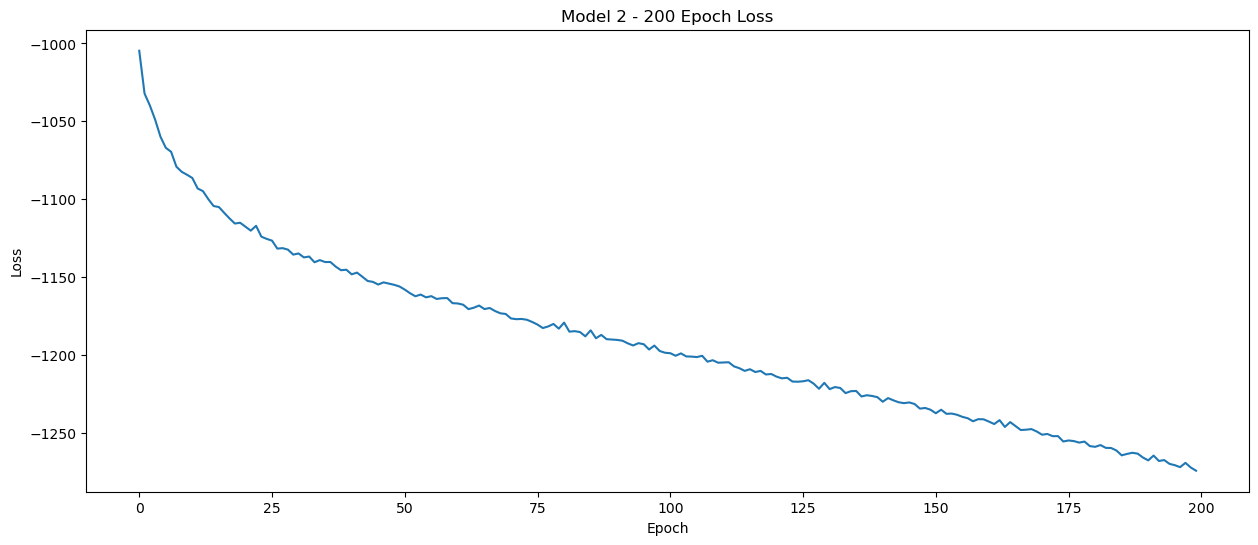

In [7]:
plt.figure(figsize=(15,6))
plt.plot(loss2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2 - 200 Epoch Loss')
plt.show()

##  2.3 Model 3 (M1: $\gamma_1 = 0.6$, $\mathrm{smooth} = \mathrm{True}$)

### (1) 参数/Parameter

- MCR2_HGPD
  - cate_dim = 8
  - hidden_dim = 16
  - num_hop = 2
- mcr_loss
  - eff = True (with smooth)
  - eps = 0.5
  - gam2 = 0.6 (Default scale of Discrim in loss calculation)
- optimizer & train
  - torch.optim.Adam(net.parameters(), lr=0.001)
  - epoch = 200
- AugmentLoader
  - batch_size = 20
  - aug_num = 50

### (2) 模型训练/Model training

In [4]:
torch.manual_seed(0)
net = MCR2_HGPD(node_num=980, feature_dim=10, cate_dim=8, hidden_dim=16, num_hop=2)

In [5]:
mcr_loss = MaximalCodingRateReduction(eff = True, eps = 0.5)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [7]:
best_folder = 'Train_record/Model/Model3/Best'
model_folder = 'Train_record/Model/Model3/Model state'
params_folder = 'Train_record/Model/Model3/Parameter'
np_path = 'Train_record/Model/Model3/All_loss.npy'

In [8]:
epoch_num = 200
loss_stand = 0
loss_array = np.zeros(epoch_num)
m_start_time = time.time()
torch.manual_seed(0)
np.random.seed(0)
net.train()
for epoch in range(epoch_num):
    node_user = net(no_Nidx = user_embed_idx,
                    u_feature = s_user_f,
                    heteData = heteroData)
    data_loader = AugmentLoader(node_user,
                                batch_size = 20,
                                aug_num = 50,
                                shuffle = False)
    loss_s = torch.tensor(0.0,requires_grad=True,device='cuda')
    '''把所有batch的loss加和；每个epoch结束后回传一次loss / Sum the loss of all batch; BP the loss at the end of each epoch'''
    for step, (batch, pseudo_label) in enumerate(data_loader):
        batch = batch.cuda()
        loss, loss_empi, loss_theo = mcr_loss(batch, 
                                              pseudo_label)
        loss_s = torch.add(loss_s, loss)
        
        if step == 0:
            step_savename = 'Model3_step.csv'
            savePara.save_step_DC(step_savename, params_folder,
                                  epoch, step,
                                  loss.item(), loss_empi[0], loss_empi[1], 
                                  loss_theo[0], loss_theo[1]) 
        elif (step+1) % 50 == 0:
            step_savename = 'Model3_step.csv'
            savePara.save_step_DC(step_savename, params_folder,
                                  epoch, step,
                                  loss.item(), loss_empi[0], loss_empi[1], 
                                  loss_theo[0], loss_theo[1])         

    optimizer.zero_grad()
    loss_s.backward()
    optimizer.step()
       
    
    loss_compare = loss_s.detach().item()
    loss_array[epoch] = loss_compare
    print(f'{epoch+1}, {loss_compare}')
    if loss_compare < loss_stand:
        model_savename = f'3Best_epoch{epoch + 1}.pt'
        savePara.save_model_state(model_savename, best_folder,
                                  epoch, net, optimizer)
        loss_stand = loss_compare
        print('Now the best is: {}'.format(epoch+1))
        
        
    if epoch == 0:
        model_savename = f'Model3_epoch{epoch + 1}.pt'
        savePara.save_model_state(model_savename, model_folder, 
                                  epoch, net, optimizer)
    elif (epoch+1) % 25 == 0:
        model_savename = f'Model3_epoch{epoch + 1}.pt'
        savePara.save_model_state(model_savename, model_folder, 
                                  epoch, net, optimizer)
    
    if epoch == 0:
        params_savename = 'Model3_params.csv'
        savePara.save_parameters_to_csv(params_savename, params_folder, 
                                        epoch, loss_s.item(), 0.001)
        
    elif (epoch+1) % 10 == 0:
        params_savename = 'Model3_params.csv'
        savePara.save_parameters_to_csv(params_savename, params_folder, 
                                        epoch, loss_s.item(), 0.001)
        print('Epoch {} finished!'.format(epoch+1))
        
m_end_time = time.time()
m_total_time = (m_end_time - m_start_time)/3600
np.save(np_path, loss_array)
print("Training complete! Total training time: {} hours".format(m_total_time))

1, -4162.240234375
Now the best is: 1
2, -4191.11865234375
Now the best is: 2
3, -4193.9736328125
Now the best is: 3
4, -4203.603515625
Now the best is: 4
5, -4217.1640625
Now the best is: 5
6, -4220.89892578125
Now the best is: 6
7, -4224.4384765625
Now the best is: 7
8, -4233.52490234375
Now the best is: 8
9, -4237.3623046875
Now the best is: 9
10, -4240.83056640625
Now the best is: 10
Epoch 10 finished!
11, -4244.4462890625
Now the best is: 11
12, -4251.4755859375
Now the best is: 12
13, -4254.673828125
Now the best is: 13
14, -4259.6396484375
Now the best is: 14
15, -4263.919921875
Now the best is: 15
16, -4264.29443359375
Now the best is: 16
17, -4268.11767578125
Now the best is: 17
18, -4271.7392578125
Now the best is: 18
19, -4275.23974609375
Now the best is: 19
20, -4276.228515625
Now the best is: 20
Epoch 20 finished!
21, -4280.064453125
Now the best is: 21
22, -4282.236328125
Now the best is: 22
23, -4281.7900390625
24, -4286.787109375
Now the best is: 24
25, -4288.8745117187

### (3) Loss可视化/Loss visualization

In [8]:
np_path = 'Train_record/Model/Model3/All_loss.npy'
loss3 = np.load(np_path)

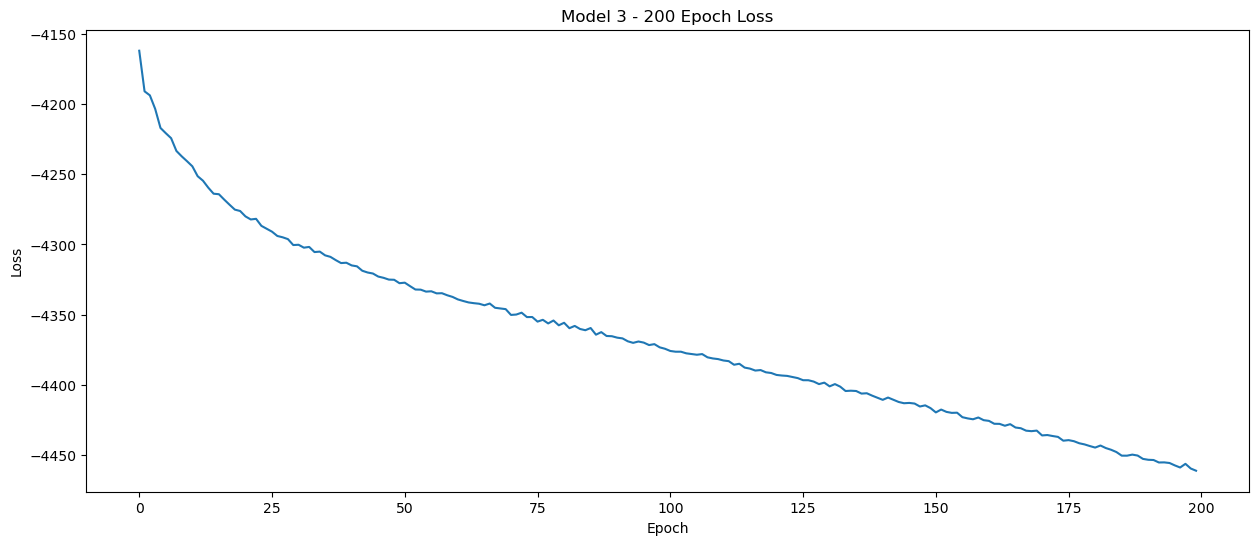

In [9]:
plt.figure(figsize=(15,6))
plt.plot(loss3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 3 - 200 Epoch Loss')
plt.show()

##  2.4 Model 4 (M2: $ \epsilon^2 = 0.5$)

### (1) 参数/Parameter

- MCR2_HGPD
  - cate_dim = 16
  - hidden_dim = 16
  - num_hop = 2
- mcr_loss
  - eff = False (without smooth)
  - eps = 0.5
  - gam2 = 0.6 (Default scale of Discrim in loss calculation)
- optimizer & train
  - torch.optim.Adam(net.parameters(), lr=0.001)
  - epoch = 200
- AugmentLoader
  - batch_size = 20
  - aug_num = 50

### (2) 模型训练/Model training

In [4]:
torch.manual_seed(0)
net = MCR2_HGPD(node_num=980, feature_dim=10, cate_dim=16, hidden_dim=16, num_hop=2)

In [5]:
mcr_loss = MaximalCodingRateReduction(eps = 0.5)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [6]:
best_folder = 'Train_record/Model/Model4/Best'
model_folder = 'Train_record/Model/Model4/Model state'
params_folder = 'Train_record/Model/Model4/Parameter'
np_path = 'Train_record/Model/Model4/All_loss.npy'

In [7]:
epoch_num = 200
loss_stand = 0
loss_array = np.zeros(epoch_num)
m_start_time = time.time()
torch.manual_seed(0)
np.random.seed(0)
net.train()
for epoch in range(epoch_num):
    node_user = net(no_Nidx = user_embed_idx,
                    u_feature = s_user_f,
                    heteData = heteroData)
    data_loader = AugmentLoader(node_user,
                                batch_size = 20,
                                aug_num = 50,
                                shuffle = False)
    loss_s = torch.tensor(0.0,requires_grad=True,device='cuda')
    '''把所有batch的loss加和；每个epoch结束后回传一次loss / Sum the loss of all batch; BP the loss at the end of each epoch'''
    for step, (batch, pseudo_label) in enumerate(data_loader):
        batch = batch.cuda()
        loss, loss_empi, loss_theo = mcr_loss(batch, 
                                              pseudo_label)
        loss_s = torch.add(loss_s, loss)
        
        if step == 0:
            step_savename = 'Model4_step.csv'
            savePara.save_step_DC(step_savename, params_folder,
                                  epoch, step,
                                  loss.item(), loss_empi[0], loss_empi[1], 
                                  loss_theo[0], loss_theo[1]) 
        elif (step+1) % 50 == 0:
            step_savename = 'Model4_step.csv'
            savePara.save_step_DC(step_savename, params_folder,
                                  epoch, step,
                                  loss.item(), loss_empi[0], loss_empi[1], 
                                  loss_theo[0], loss_theo[1])         

    optimizer.zero_grad()
    loss_s.backward()
    optimizer.step()
        

    loss_compare = loss_s.detach().item()
    loss_array[epoch] = loss_compare
    print(f'{epoch+1}, {loss_compare}')
    if loss_compare < loss_stand:
        model_savename = f'4Best_epoch{epoch + 1}.pt'
        savePara.save_model_state(model_savename, best_folder,
                                  epoch, net, optimizer)
        loss_stand = loss_compare
        print('Now the best is: {}'.format(epoch+1))
        
  
    if epoch == 0:
        model_savename = f'Model4_epoch{epoch + 1}.pt'
        savePara.save_model_state(model_savename, model_folder, 
                                  epoch, net, optimizer)
    elif (epoch+1) % 25 == 0:
        model_savename = f'Model4_epoch{epoch + 1}.pt'
        savePara.save_model_state(model_savename, model_folder, 
                                  epoch, net, optimizer)
    
    if epoch == 0:
        params_savename = 'Model4_params.csv'
        savePara.save_parameters_to_csv(params_savename, params_folder, 
                                        epoch, loss_s.item(), 0.001)
        
    elif (epoch+1) % 10 == 0:
        params_savename = 'Model4_params.csv'
        savePara.save_parameters_to_csv(params_savename, params_folder, 
                                        epoch, loss_s.item(), 0.001)
        print('Epoch {} finished!'.format(epoch+1))
        
m_end_time = time.time()
m_total_time = (m_end_time - m_start_time)/3600
np.save(np_path, loss_array)
print("Training complete! Total training time: {} hours".format(m_total_time))

1, -1009.0474243164062
Now the best is: 1
2, -1043.831298828125
Now the best is: 2
3, -1057.0701904296875
Now the best is: 3
4, -1072.0528564453125
Now the best is: 4
5, -1076.84521484375
Now the best is: 5
6, -1085.2042236328125
Now the best is: 6
7, -1090.0391845703125
Now the best is: 7
8, -1096.0755615234375
Now the best is: 8
9, -1097.932861328125
Now the best is: 9
10, -1102.8939208984375
Now the best is: 10
Epoch 10 finished!
11, -1106.0386962890625
Now the best is: 11
12, -1109.5587158203125
Now the best is: 12
13, -1109.57080078125
Now the best is: 13
14, -1113.2015380859375
Now the best is: 14
15, -1116.61181640625
Now the best is: 15
16, -1117.74853515625
Now the best is: 16
17, -1121.521484375
Now the best is: 17
18, -1121.5538330078125
Now the best is: 18
19, -1125.905517578125
Now the best is: 19
20, -1126.3001708984375
Now the best is: 20
Epoch 20 finished!
21, -1128.678466796875
Now the best is: 21
22, -1130.8143310546875
Now the best is: 22
23, -1129.7945556640625
24, 

### (3) Loss可视化/Loss visualization

In [10]:
np_path = 'Train_record/Model/Model4/All_loss.npy'
loss4 = np.load(np_path)

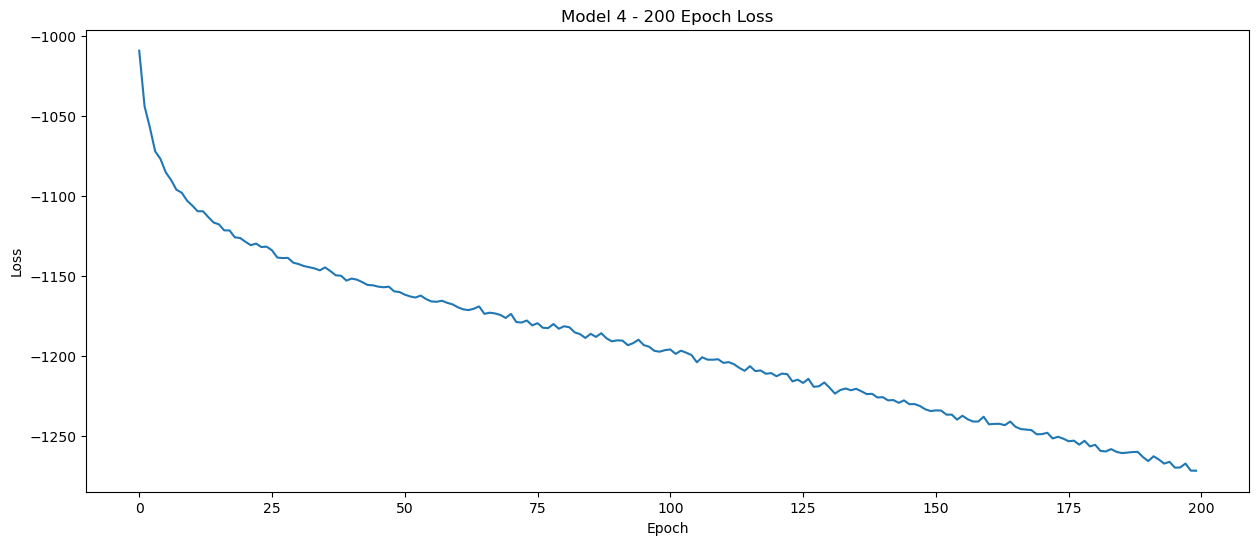

In [11]:
plt.figure(figsize=(15,6))
plt.plot(loss4)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 4 - 200 Epoch Loss')
plt.show()

##  2.5 Model 5 (M2: $\epsilon^2 = 0.3$)

### (1) 参数/Parameter

- MCR2_HGPD
  - cate_dim = 16
  - hidden_dim = 16
  - num_hop = 2
- mcr_loss
  - eff = False (without smooth)
  - eps = 0.3
  - gam2 = 0.6 (Default scale of Discrim in loss calculation)
- optimizer & train
  - torch.optim.Adam(net.parameters(), lr=0.001)
  - epoch = 200
- AugmentLoader
  - batch_size = 20
  - aug_num = 50

### (2) 模型训练/Model training

In [4]:
torch.manual_seed(0)
net = MCR2_HGPD(node_num=980, feature_dim=10, cate_dim=16, hidden_dim=16, num_hop=2)

In [5]:
mcr_loss = MaximalCodingRateReduction(eps = 0.3)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [6]:
best_folder = 'Train_record/Model/Model5/Best'
model_folder = 'Train_record/Model/Model5/Model state'
params_folder = 'Train_record/Model/Model5/Parameter'
np_path = 'Train_record/Model/Model5/All_loss.npy'

In [7]:
epoch_num = 200
loss_stand = 0
loss_array = np.zeros(epoch_num)
m_start_time = time.time()
torch.manual_seed(0)
np.random.seed(0)
net.train()
for epoch in range(epoch_num):
    node_user = net(no_Nidx = user_embed_idx,
                    u_feature = s_user_f,
                    heteData = heteroData)
    data_loader = AugmentLoader(node_user,
                                batch_size = 20,
                                aug_num = 50,
                                shuffle = False)
    loss_s = torch.tensor(0.0,requires_grad=True,device='cuda')
    '''把所有batch的loss加和；每个epoch结束后回传一次loss / Sum the loss of all batch; BP the loss at the end of each epoch'''
    for step, (batch, pseudo_label) in enumerate(data_loader):
        batch = batch.cuda()
        loss, loss_empi, loss_theo = mcr_loss(batch, 
                                              pseudo_label)
        loss_s = torch.add(loss_s, loss)
        
        if step == 0:
            step_savename = 'Model5_step.csv'
            savePara.save_step_DC(step_savename, params_folder,
                                  epoch, step,
                                  loss.item(), loss_empi[0], loss_empi[1], 
                                  loss_theo[0], loss_theo[1]) 
        elif (step+1) % 50 == 0:
            step_savename = 'Model5_step.csv'
            savePara.save_step_DC(step_savename, params_folder,
                                  epoch, step,
                                  loss.item(), loss_empi[0], loss_empi[1], 
                                  loss_theo[0], loss_theo[1])         

    optimizer.zero_grad()
    loss_s.backward()
    optimizer.step()
        

    loss_compare = loss_s.detach().item()
    loss_array[epoch] = loss_compare
    print(f'{epoch+1}, {loss_compare}')
    if loss_compare < loss_stand:
        model_savename = f'5Best_epoch{epoch + 1}.pt'
        savePara.save_model_state(model_savename, best_folder,
                                  epoch, net, optimizer)
        loss_stand = loss_compare
        print('Now the best is: {}'.format(epoch+1))
        
    
    if epoch == 0:
        model_savename = f'Model5_epoch{epoch + 1}.pt'
        savePara.save_model_state(model_savename, model_folder, 
                                  epoch, net, optimizer)
    elif (epoch+1) % 25 == 0:
        model_savename = f'Model5_epoch{epoch + 1}.pt'
        savePara.save_model_state(model_savename, model_folder, 
                                  epoch, net, optimizer)
    
    if epoch == 0:
        params_savename = 'Model5_params.csv'
        savePara.save_parameters_to_csv(params_savename, params_folder, 
                                        epoch, loss_s.item(), 0.001)
        
    elif (epoch+1) % 10 == 0:
        params_savename = 'Model5_params.csv'
        savePara.save_parameters_to_csv(params_savename, params_folder, 
                                        epoch, loss_s.item(), 0.001)
        print('Epoch {} finished!'.format(epoch+1))
        
m_end_time = time.time()
m_total_time = (m_end_time - m_start_time)/3600
np.save(np_path, loss_array)
print("Training complete! Total training time: {} hours".format(m_total_time))

1, -724.4489135742188
Now the best is: 1
2, -759.24169921875
Now the best is: 2
3, -772.546630859375
Now the best is: 3
4, -787.4896240234375
Now the best is: 4
5, -792.3648071289062
Now the best is: 5
6, -800.7647094726562
Now the best is: 6
7, -805.5044555664062
Now the best is: 7
8, -811.6428833007812
Now the best is: 8
9, -813.3541870117188
Now the best is: 9
10, -818.3885498046875
Now the best is: 10
Epoch 10 finished!
11, -821.588623046875
Now the best is: 11
12, -825.0465087890625
Now the best is: 12
13, -825.0471801757812
Now the best is: 13
14, -828.6268310546875
Now the best is: 14
15, -832.0648193359375
Now the best is: 15
16, -833.1910400390625
Now the best is: 16
17, -836.9822387695312
Now the best is: 17
18, -837.0381469726562
Now the best is: 18
19, -841.4117431640625
Now the best is: 19
20, -841.7573852539062
Now the best is: 20
Epoch 20 finished!
21, -844.2037963867188
Now the best is: 21
22, -846.3472290039062
Now the best is: 22
23, -845.2318115234375
24, -847.485534

### (3) Loss可视化/Loss visualization

In [12]:
np_path = 'Train_record/Model/Model5/All_loss.npy'
loss5 = np.load(np_path)

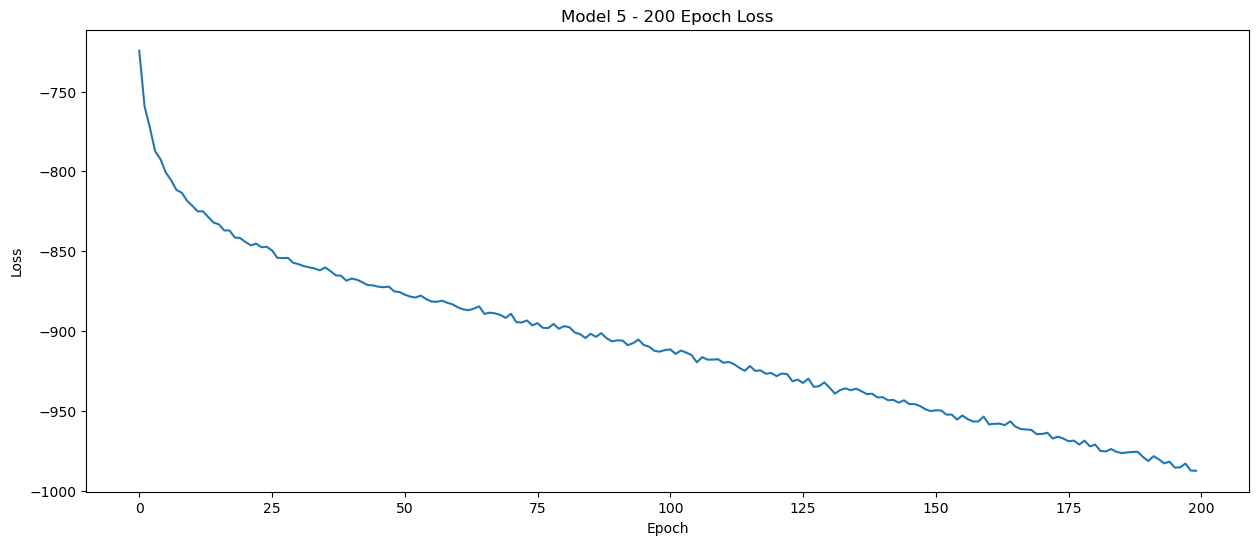

In [13]:
plt.figure(figsize=(15,6))
plt.plot(loss5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 5 - 200 Epoch Loss')
plt.show()

##  2.6 Model 6 (M2: $\epsilon^2 = 0.7$)

### (1) 参数/Parameter

- MCR2_HGPD
  - cate_dim = 16
  - hidden_dim = 16
  - num_hop = 2
- mcr_loss
  - eff = False (without smooth)
  - eps = 0.7
  - gam2 = 0.6 (Default scale of Discrim in loss calculation)
- optimizer & train
  - torch.optim.Adam(net.parameters(), lr=0.001)
  - epoch = 200
- AugmentLoader
  - batch_size = 20
  - aug_num = 50


### (2) 模型训练/Model training

In [4]:
torch.manual_seed(0)
net = MCR2_HGPD(node_num=980, feature_dim=10, cate_dim=16, hidden_dim=16, num_hop=2)

In [5]:
mcr_loss = MaximalCodingRateReduction(eps = 0.7)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [6]:
best_folder = 'Train_record/Model/Model6/Best'
model_folder = 'Train_record/Model/Model6/Model state'
params_folder = 'Train_record/Model/Model6/Parameter'
np_path = 'Train_record/Model/Model6/All_loss.npy'

In [7]:
epoch_num = 200
loss_stand = 0
loss_array = np.zeros(epoch_num)
m_start_time = time.time()
torch.manual_seed(0)
np.random.seed(0)
net.train()
for epoch in range(epoch_num):
    node_user = net(no_Nidx = user_embed_idx,
                    u_feature = s_user_f,
                    heteData = heteroData)
    data_loader = AugmentLoader(node_user,
                                batch_size = 20,
                                aug_num = 50,
                                shuffle = False)
    loss_s = torch.tensor(0.0,requires_grad=True,device='cuda')
    '''把所有batch的loss加和；每个epoch结束后回传一次loss / Sum the loss of all batch; BP the loss at the end of each epoch'''
    for step, (batch, pseudo_label) in enumerate(data_loader):
        batch = batch.cuda()
        loss, loss_empi, loss_theo = mcr_loss(batch, 
                                              pseudo_label)
        loss_s = torch.add(loss_s, loss)
        
        if step == 0:
            step_savename = 'Model6_step.csv'
            savePara.save_step_DC(step_savename, params_folder,
                                  epoch, step,
                                  loss.item(), loss_empi[0], loss_empi[1], 
                                  loss_theo[0], loss_theo[1]) 
        elif (step+1) % 50 == 0:
            step_savename = 'Model6_step.csv'
            savePara.save_step_DC(step_savename, params_folder,
                                  epoch, step,
                                  loss.item(), loss_empi[0], loss_empi[1], 
                                  loss_theo[0], loss_theo[1])         

    optimizer.zero_grad()
    loss_s.backward()
    optimizer.step()
        
    
    loss_compare = loss_s.detach().item()
    loss_array[epoch] = loss_compare
    print(f'{epoch+1}, {loss_compare}')
    if loss_compare < loss_stand:
        model_savename = f'6Best_epoch{epoch + 1}.pt'
        savePara.save_model_state(model_savename, best_folder,
                                  epoch, net, optimizer)
        loss_stand = loss_compare
        print('Now the best is: {}'.format(epoch+1))
        
    
    if epoch == 0:
        model_savename = f'Model6_epoch{epoch + 1}.pt'
        savePara.save_model_state(model_savename, model_folder, 
                                  epoch, net, optimizer)
    elif (epoch+1) % 25 == 0:
        model_savename = f'Model6_epoch{epoch + 1}.pt'
        savePara.save_model_state(model_savename, model_folder, 
                                  epoch, net, optimizer)
    
    if epoch == 0:
        params_savename = 'Model6_params.csv'
        savePara.save_parameters_to_csv(params_savename, params_folder, 
                                        epoch, loss_s.item(), 0.001)
        
    elif (epoch+1) % 10 == 0:
        params_savename = 'Model6_params.csv'
        savePara.save_parameters_to_csv(params_savename, params_folder, 
                                        epoch, loss_s.item(), 0.001)
        print('Epoch {} finished!'.format(epoch+1))
        
m_end_time = time.time()
m_total_time = (m_end_time - m_start_time)/3600
np.save(np_path, loss_array)
print("Training complete! Total training time: {} hours".format(m_total_time))

1, -1188.32666015625
Now the best is: 1
2, -1223.1009521484375
Now the best is: 2
3, -1236.1861572265625
Now the best is: 3
4, -1251.339599609375
Now the best is: 4
5, -1256.0450439453125
Now the best is: 5
6, -1264.2244873046875
Now the best is: 6
7, -1269.3565673828125
Now the best is: 7
8, -1275.2513427734375
Now the best is: 8
9, -1277.095458984375
Now the best is: 9
10, -1282.16845703125
Now the best is: 10
Epoch 10 finished!
11, -1285.104736328125
Now the best is: 11
12, -1288.6844482421875
Now the best is: 12
13, -1288.8682861328125
Now the best is: 13
14, -1292.4661865234375
Now the best is: 14
15, -1295.783935546875
Now the best is: 15
16, -1296.93359375
Now the best is: 16
17, -1300.6844482421875
Now the best is: 17
18, -1300.7593994140625
Now the best is: 18
19, -1305.1175537109375
Now the best is: 19
20, -1305.545166015625
Now the best is: 20
Epoch 20 finished!
21, -1307.842529296875
Now the best is: 21
22, -1309.96923828125
Now the best is: 22
23, -1309.0576171875
24, -131

### (3) Loss可视化/Loss visualization

In [14]:
np_path = 'Train_record/Model/Model6/All_loss.npy'
loss6 = np.load(np_path)

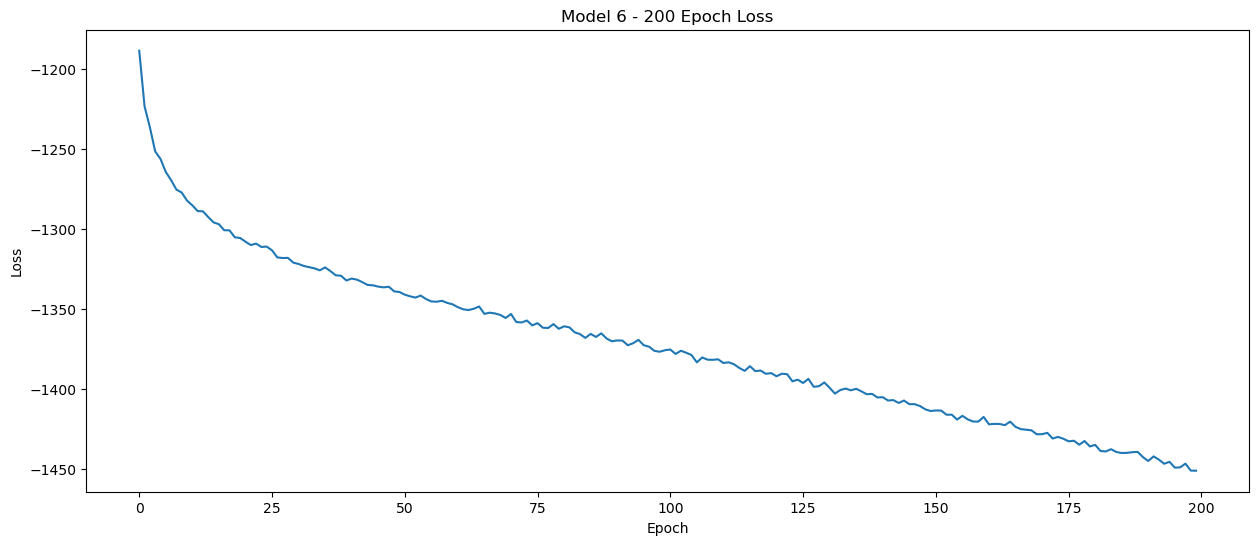

In [15]:
plt.figure(figsize=(15,6))
plt.plot(loss6)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 6 - 200 Epoch Loss')
plt.savefig('W:/0_Levia/Code/7002/0_Final/Model20/M20_loss.eps')
plt.show()